# **Modelling and Evaluation Notebook**

## Objectives
TODO 
* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* inputs/cherry-leaves-dataset/cherry-leaves/train
* inputs/cherry-leaves-dataset/cherry-leaves/test
* inputs/cherry-leaves-dataset/cherry-leaves/validation
* image shape embeddings pickle file

## Outputs
TODO
* v1:
    * class_distribution.png  
    * class_indices.pkl  
    * evaluation.pkl
    * image_shape.pkl  
    * model_v1.keras  
    * training_accuracy_v1.png  
    * training_loss_v1.png 

## Additional Comments
TODO
* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

### Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-ML/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-ML'

### Set input directory

In [5]:
my_data_dir = 'inputs/cherry-leaves-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Gather labels

In [7]:
labels = os.listdir(train_path)

print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Load image shape embeddings

In [42]:
## Import saved image shape embedding pickle file
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

***

# Review class distribution

* across whole dataset
* per train, test, and validation

* train- healthy: 1472 images

* train- powdery_mildew: 1472 images

* validation- healthy: 210 images

* validation- powdery_mildew: 210 images

* test- healthy: 422 images

* test- powdery_mildew: 422 images

4208 images total
--------


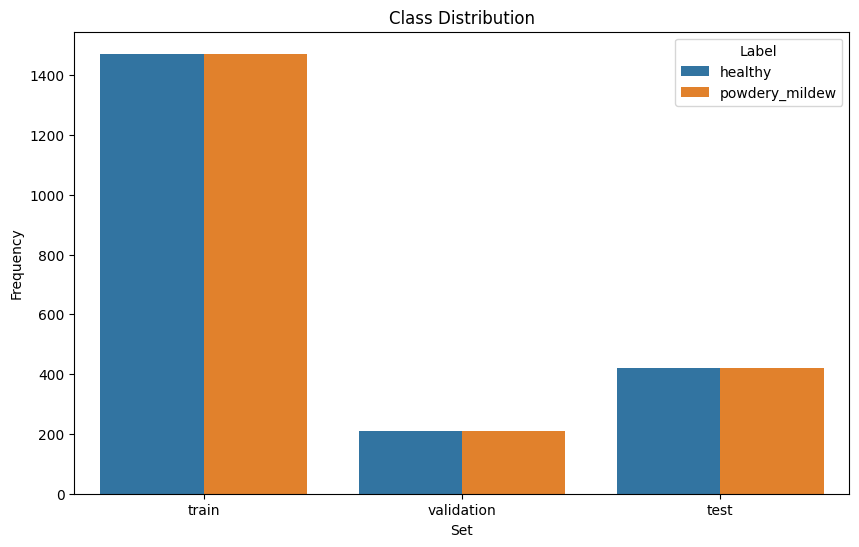



--------
                Frequency         Set  Percent of DataSet
Label                                                    
healthy            1472.0       train                35.0
powdery_mildew     1472.0       train                35.0
healthy             210.0  validation                 5.0
powdery_mildew      210.0  validation                 5.0
healthy             422.0        test                10.0
powdery_mildew      422.0        test                10.0


In [35]:
df_freq = pd.DataFrame([])
total_images_count = 0

# gather info
for folder in ['train', 'validation', 'test']:
    for label in labels:

        path = my_data_dir + '/' + folder + '/' + label
        
        image_count = int(len(os.listdir(path)))
        total_images_count += image_count

        df_freq = df_freq.append(pd.Series(
            {'Set': folder,
             'Label': label,
             'Frequency': image_count},
            ), ignore_index=True )
        print(f"* {folder}- {label}: {image_count} images\n")

print(f'{total_images_count} images total')
print('--------')

### plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Set', y='Frequency', hue='Label', data=df_freq)
plt.title('Class Distribution')
plt.savefig(f'{file_path}/class_distribution.png', bbox_inches='tight', dpi=600)
plt.show()
print('\n')

print('--------')

# confirm percentages of dataset
df_freq.set_index('Label', inplace=True)
df_freq['Percent of DataSet'] = round(df_freq['Frequency'] / total_images_count * 100)
print(df_freq)




***

# Image Augmentation

### Define image data generator, initialize


In [36]:
# This function generates batches of image data with real-time data augmentation.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize
# TODO check changing colors, highlighting certain colors or something else
# TODO READ https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/
# TODO after testing, check effect, change or add params if wanted:
# TODO https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?hl=en
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,  # zoom by 10%
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255  # between 0 and 500 pixels large
                                          )

### Augment TRAINING image dataset


In [37]:
batch_size = 20  # TODO Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Aubment VALIDATION image dataset


In [38]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment TEST image dataset

In [39]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

(20, 256, 256, 3)

--------------


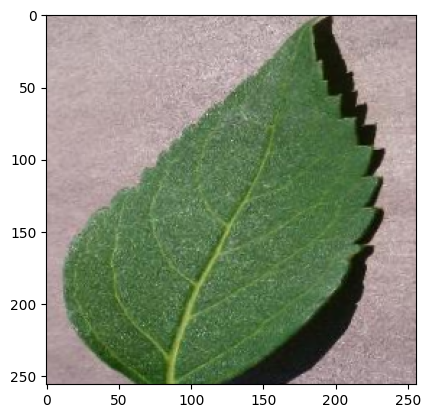

(20, 256, 256, 3)

--------------


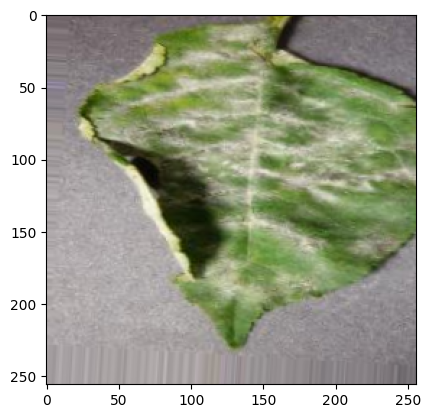

(20, 256, 256, 3)

--------------


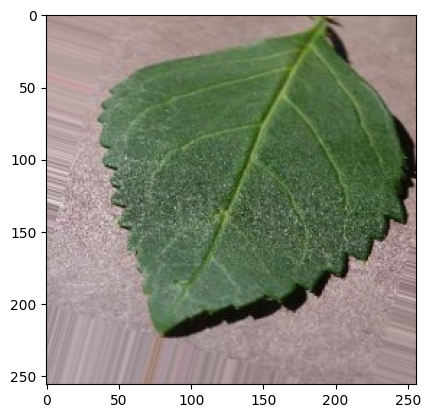

In [40]:
for _ in range(3):
    img, label = train_set.next()
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()

    # expect: batch, width, height, RGB

### Plot augmented validation and test images

(20, 256, 256, 3)

--------------


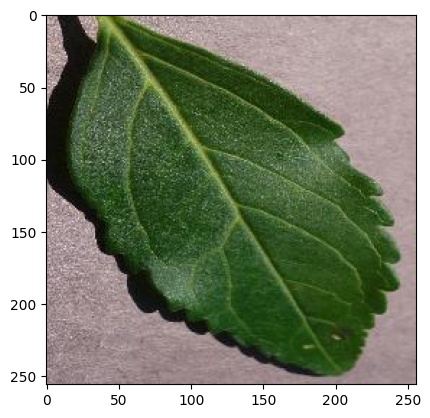

(20, 256, 256, 3)

--------------


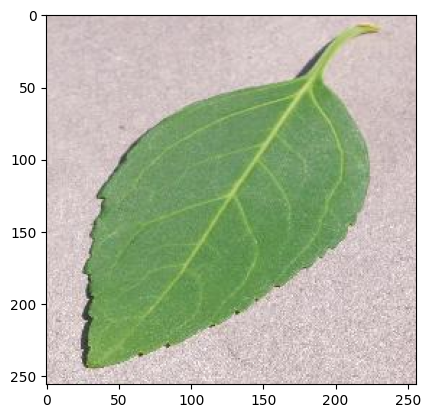

(20, 256, 256, 3)

--------------


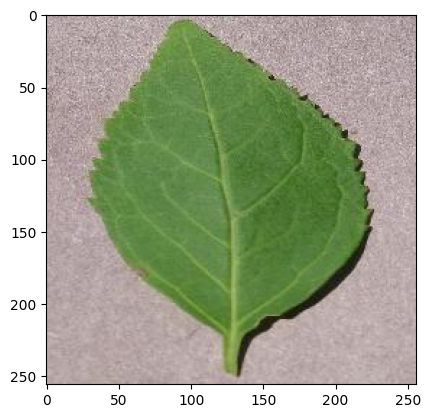

In [41]:
for _ in range(3):  # test augmentation has worked
    img, label = validation_set.next()
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()

    # batch size, height, width, channels (RGB)

###  Observations
Augmented validation and test images have been standardized between 0 to 255 pixels. As you can see, the images are ugmented and are ready to be used for developing and training a CNN model.

### Save class indices

In [ ]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

---

# Model Creation

---

### ML Model

* Import model packages

In [17]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D



* ### Model

In [18]:
def create_tf_model():
    """
    input shape = saved input shape (256, 256, 3)

    """
    model = Sequential()

    # Input layer, first convolution block
    model.add(Conv2D(filters=32, kernel_size=(3, 3),  # find dominant pixels
        input_shape=image_shape,  # average image shape
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2))) # extract only dominant features

    # Second convolution block
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
        input_shape=image_shape,
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Third convolution block
    model.add(Conv2D(
        filters=128,  # increase
        kernel_size=(3,3),
        input_shape=image_shape,
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Fourth convolution block
    model.add(Conv2D(
        filters=256,  # increase
        kernel_size=(3,3),
        input_shape=image_shape,
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Dropout
    model.add(Dropout(0.5)) # drop 50% to avoid overfitting 
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy', 
            # tensorflow.keras.metrics.Precision(), 
            # tensorflow.keras.metrics.Recall()
        ])

    return model


In [ ]:
summary = create_tf_model().summary()

* Early Stopping

    * Avoid overfitting

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=3)

# Visaulise Model

In [ ]:
# TODO remove if neccessary
from tensorflow.keras.utils import plot_model

model = create_tf_model

plot_model(model, show_shapes=True)

***

# Create Model v1

In [ ]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

### Save model

In [ ]:
model.save('outputs/v1/cherry-tree-model.h5')

*** 

# Evaluate Model Performance 

In [41]:
def confusion_matrix_and_report(X,y,pipeline,label_map):
    prediction = pipeline.predict(X).reshape(-1)
    prediction = np.where(prediction<0.5,0,1)
    # the prediction using sigmoid as an activation function is a probability number, between 0 and 1
    # we convert it to 0 or 1, if it is lower than 0.5, the predicted class is 0, otherwise it is 1
    # you could change the threshold if you want.
    print('--- Confusion Matrix ---')
    print(
        pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ],
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
    print("\n")
    print('--- Classification Report ---')
    print(classification_report(y, prediction, target_names=label_map),"\n")


def clf_performance(X_train,y_train,X_test,y_test,X_val, y_val,pipeline,label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

    print("#### Validation Set #### \n")
    confusion_matrix_and_report(X_val,y_val,pipeline,label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('outputs/v1/cherry-tree-model.h5')
# TODO # update tensorflow to newer version?????????????
# Show the model architecture

model.summary()

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot(style='.-')
plt.title('Loss')
plt.savefig(f'{file_path}/training_loss.png', bbox_inches='tight', dpi=600)
print('\n')
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title('Accuracy')
plt.savefig(f'{file_path}/training_accuracy.png', bbox_inches='tight', dpi=600)

### Evaluate and save

In [ ]:
evaluation = model.evaluate(test_set)

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

# Run Live Prediction 

from tensorflow.keras.preprocessing import image

pointer = 66  # TODO change to random within length of dir
label = labels[1]  # select Uninfected or Parasitised # TODO change to random (0 or 1) and print image class too

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [ ]:
pred_img = image.img_to_array(pil_image)
pred_img = np.expand_dims(pred_img, axis=0)/255
print(pred_img.shape)
pred_img

In [ ]:
# predict class probability on test image
pred_proba = model.predict(pred_img)[0, 0] # why 0 0?

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
  pred_proba = 1 - pred_proba

print(f'Prediction: {pred_class}\nConfidence: {pred_proba*100:.1f}%') # TODO edit syntax/.1f to more?

## Evaluation:

Given that the training data, whilst augmented was very small, I believe this has caused overfitting and a lack of proper deep learning, leading to 100% certainty.
Now that I have defined a first iteration of model 1, 

## Next steps:
* Define clear pipelines 
    * clear normalisation
    * clear image augmentation
        * more img aug parameters including:
            * brightness
            * color
            * random cropping
            * rotation
    * clear hypertuning 
    * clear evaluation process: 
        * plot confusion matrix
        * classicication report

*** 

In [43]:
import joblib
evaluation = joblib.load('outputs/v1/evaluation.pkl')
evaluation # loss, accuracy? TODO confirm

[0.03199880197644234, 0.9881516695022583]

# Model v2

In [ ]:
import os
